# Optimization For Data Science Project
#### ODS Final Project
Shehroz Ali, Alexandra Pilipyuk, Adriano Rasetta


---


### Methods for Deep Learning 
### Classification task: Digit MNIST


### Libraries

In [ ]:
import os
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torch.nn import Sequential

### Dataset

In [ ]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Datsets

print(train_dataset, "\n")
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train 

Dataset MNIST
    Number of datapoints: 10000
    Root location: classifier_data
    Split: Test


Tuple: (<PIL.Image.Image image mode=L size=28x28 at 0x7FAA59E165D0>, 5)

Image format: <PIL.Image.Image image mode=L size=28x28 at 0x7FAA59E167D0>

Sample at index: 0

Label: 7

Image:



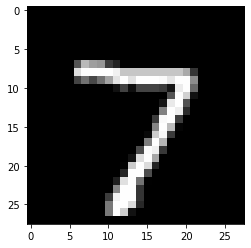

In [ ]:
# How to get an image (PIL image) and the corresponding label

sample_index = 0
image = test_dataset[sample_index][0]
label = test_dataset[sample_index][1]

fig = plt.figure(figsize=(4,4))
plt.imshow(image, cmap='gist_gray')
print(f"Tuple:", train_dataset[sample_index])
print(f"\nImage format:", train_dataset[sample_index][0])
print(f"\nSample at index: {sample_index}")
print(f"\nLabel: {label}")
print("\nImage:\n")

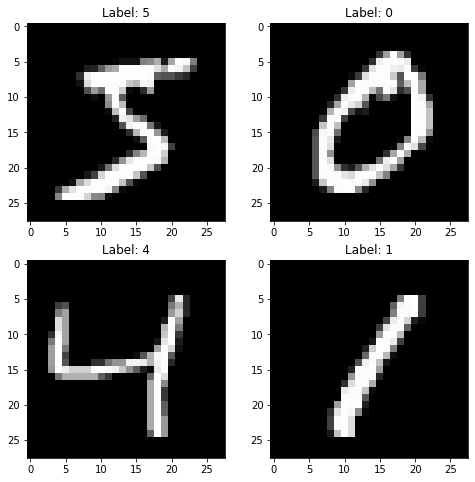

In [ ]:
# Some image samples

plt.figure(figsize=(8, 8))

for sample_index in range(4):
  im = train_dataset[sample_index][0]
  lab = train_dataset[sample_index][1]

  plt.subplot(2,2,sample_index+1)
  plt.title(f"Label: {lab}")
  plt.imshow(im, cmap='gist_gray')

In [ ]:
# Tensor transformation of all dataset

train_trans = transforms.ToTensor()
test_trans = transforms.ToTensor()

train_dataset.transform = train_trans
test_dataset.transform = test_trans

# Training set
print(f"\nTensor shape: {train_dataset[sample_index][0].shape}")
print(f"\nTensor label at index {sample_index}: {train_dataset[sample_index][1]}")

# Test Set
print(f"\nTensor shape:", test_dataset[sample_index][0].shape)
print(f"\nTensor label at index {sample_index}: {test_dataset[sample_index][1]}")


Tensor shape: torch.Size([1, 28, 28])

Tensor label at index 3: 1

Tensor shape: torch.Size([1, 28, 28])

Tensor label at index 3: 0


In [ ]:
# Split train (50000 samples) and validation set (10000 samples) 

torch.manual_seed(0)
train_dataset_new, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

print(f"Train set length: {len(train_dataset_new)}")
print(f"\nValidation set length: {len(val_dataset)}")
print(f"\nTest set length: {len(test_dataset)}")
print(f"\nWhole train set for the train of the best model: {len(train_dataset)}")

Train set length: 50000

Validation set length: 10000

Test set length: 10000

Whole train set for the train of the best model: 60000


In [ ]:
# Dataloader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True,  num_workers=2)
train_dataloader_new = DataLoader(dataset=train_dataset_new, batch_size=50, shuffle=True,  num_workers=2)
validation_dataloader   = DataLoader(dataset=val_dataset,   batch_size=len(val_dataset),  shuffle=False, num_workers=2) 
test_dataloader  = DataLoader(dataset=test_dataset,  batch_size=len(test_dataset),  shuffle=False, num_workers=2)

In [ ]:
# Dimension exploration of dataloaders

# Train batch
image_batch, label_batch = next(iter(train_dataloader_new))
print(f"\nTrain input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")

# Validation batch
image_batch, label_batch = next(iter(validation_dataloader))
print(f"\nValidation input batch shape: {image_batch.shape}")
print(f"Validation label batch shape: {label_batch.shape}")

# Test batch
image_batch, label_batch = next(iter(test_dataloader))
print(f"\nTest input batch shape: {image_batch.shape}")
print(f"Test label batch shape: {label_batch.shape}")

# Train batch (Whole train set)
print("\nTrain batch of the train set for the best model:")
image_batch, label_batch = next(iter(train_dataloader))
print(f"Train input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")



Train input batch shape: torch.Size([50, 1, 28, 28])
Train label batch shape: torch.Size([50])

Validation input batch shape: torch.Size([10000, 1, 28, 28])
Validation label batch shape: torch.Size([10000])

Test input batch shape: torch.Size([10000, 1, 28, 28])
Test label batch shape: torch.Size([10000])

Train batch of the train set for the best model:
Train input batch shape: torch.Size([50, 1, 28, 28])
Train label batch shape: torch.Size([50])


### Model

In [ ]:
class Net(nn.Module):
    
    def __init__(self, Nh1 = 64, Nh2 = 64): # Structure of the network, definition of the structural parameters
        """
        Nh1 - Neurons in the first hidden layer
        Nh2 - Neurons in the second hidden layer
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=784, out_features=Nh1) # Input neurons 784 (28x28)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=10) # Output neurons 10 (classes)
        self.act = nn.ReLU(inplace=True)
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x): 
        x = self.act(self.fc1(x)) 
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

    
    def reset_weights(model):
        torch.manual_seed(0)
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

### Training and testing function

In [ ]:
# Training function

def train_function(model, device, train_dataloader, validation_dataloader, num_epochs, optimizer):
    """
    Input: model, device, train dataloader, validation dataloader, number of epochs, optimizer
    Output: list of (batch average) train losses (one for each epoch), list of (batch average) validation losses (one for each epoch)
    """
    torch.manual_seed(0)
    model.reset_weights() # Reset of the weights 
    loss_function = nn.CrossEntropyLoss() # Loss function
    
    train_loss_epochs = []
    accuracy_train_epochs = []
    
    val_loss_epochs = []
    accuracy_val_epochs = []

    for epoch_num in range(num_epochs):
      print(f'-> Epoch {epoch_num + 1}\n')

      # TRAIN
      train_loss= []
      accuracy_batch_train = []
      model.train() # Training mode 
      for sample_batched in train_dataloader:
        
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Batch sample reshaping
        x_batch = x_batch.view(50, 1, 784) # From [50, 1, 28, 28] to [50, 1, 784]

        # Forward pass
        out = model(x_batch)

        # Output reshaping
        out = out.view(50, 10)  # From [50, 1, 10] to [50, 10]

        # Compute loss
        loss = loss_function(out, label_batch) 

        # Backpropagation
        model.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step(lambda: float(loss))

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch) 

        # Prediction for training set
        softmax = torch.exp(out).cpu()
        prob = list(softmax.detach().numpy())
        predictions = np.argmax(prob, axis=1)

        # Save accuracy for this batch
        accuracy_batch_train.append(accuracy_score(label_batch.cpu(), predictions))

      # Save average train loss for this epoch
      train_loss = np.mean(train_loss) 
      print(f"Train loss: {train_loss}") 
      train_loss_epochs.append(train_loss) # List of the losses (= number of epochs) 

      # Save average accuracy for this epoch
      accuracy_batch_train = np.mean(accuracy_batch_train) 
      print(f"Accuracy on training set: {accuracy_batch_train}\n")
      accuracy_train_epochs.append(accuracy_batch_train) # List of the accuracies (= number of epochs) 
      

      # VALIDATION
      val_loss = []
      accuracy_batch_val = []
      model.eval()
      with torch.no_grad():
        for sample_batched in validation_dataloader: # If "batch_size=len(validation_dataset)" in validation_loder we have only one value (one iteration for the cycle)

            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Batch sample reshaping
            x_batch = x_batch.view(10000, 1, 784) # From [10000, 1, 28, 28] to [10000, 1, 784]

            # Forward pass
            out = model(x_batch)

            # Output reshaping
            out = out.view(10000, 10)  # From [10000, 1, 10] to [10000, 10]

            # Compute loss
            loss = loss_function(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

            # Prediction for validation set
            softmax = torch.exp(out).cpu()
            prob = list(softmax.detach().numpy())
            predictions = np.argmax(prob, axis=1)

            # Save accuracy for this batch
            accuracy_batch_val.append(accuracy_score(label_batch.cpu(), predictions))
      
        # Save average validation loss for this epoch
        val_loss = np.mean(val_loss) # Validation loss calculated after each epoch
        print(f"Validation loss: {val_loss}") 
        val_loss_epochs.append(val_loss)

        # Save average accuracy for this epoch
        accuracy_batch_val = np.mean(accuracy_batch_val) 
        print(f"Accuracy on validation set: {accuracy_batch_val}\n")
        accuracy_val_epochs.append(accuracy_batch_val) # List of the accuracies (= number of epochs) 

    return train_loss_epochs, accuracy_train_epochs, val_loss_epochs, accuracy_val_epochs

### Optimizers

#### Adam

In [ ]:
class Adam_optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, beta_1=0.9, beta_2=0.999, eps=1e-8):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} < 0".format(lr))
        if not 0.0 <= beta_1 < 1.0:
            raise ValueError("Invalid parameter beta_1: {} not in [0; 1)".format(beta_1))
        if not 0.0 <= beta_2 < 1.0:
            raise ValueError("Invalid parameter beta_2: {} not in [0; 1)".format(beta_2))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {} < 0".format(eps))

        defaults = dict(lr=lr, betas=(beta_1, beta_2), eps=eps)
        super(Adam_optimizer, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group["params"]:
                self.state[param]['step'] = 0
                self.state[param]['m'] = torch.zeros_like(param.data)
                self.state[param]['v'] = torch.zeros_like(param.data)

    def step(self, closure=None):
        for group in self.param_groups:
            for param in group["params"]:
                if param.grad is None:
                    continue

                grad = param.grad.data
                
                state = self.state[param]
                m = state['m']
                v = state['v']
                beta_1, beta_2 = group['betas']
                state['step'] += 1

                m = m * beta_1 + (1 - beta_1) * grad
                v = v * beta_2 + (1 - beta_2) * grad * grad

                m_hat = m / (1 - beta_1 ** state['step'])
                v_hat = v / (1 - beta_2 ** state['step'])

                param.data -= group['lr'] * m_hat / (v_hat.sqrt() + group['eps'])

                state['m'] = m
                state['v'] = v

        return None

#### Adagrad

In [ ]:
class AdaGrad_optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} < 0".format(lr))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {} < 0".format(eps))
            
        defaults = dict(lr=lr, eps=eps)
        super(AdaGrad_optimizer, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group["params"]:
                self.state[param]['step'] = 0
                self.state[param]['G'] = 0

    def step(self, closure=None):
        for group in self.param_groups:
            for param in group["params"]:
                if param.grad is None:
                    continue

                grad = param.grad.data
                
                state = self.state[param]
                state['G'] += grad * grad
                state['step'] += 1

                param.data -= group['lr'] * grad / (state['G'] + group['eps']).sqrt()

        return None

#### Deep Frank-Wolf

In [ ]:
class DFW_optimizer(optim.Optimizer):

    def __init__(self, params, eta, momentum=0.9, eps=1e-8):
        if eta <= 0.0:
            raise ValueError("Invalid eta: {} < 0".format(eta))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {} < 0".format(momentum))

        defaults = dict(eta=eta, momentum=momentum, eps=eps)
        super(DFW_optimizer, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group['params']:
                self.state[param]['z'] = torch.zeros_like(param.data)

    def step(self, closure):
        loss = float(closure())

        for group in self.param_groups:
            eta = group['eta']
            mu = group['momentum']
            eps = group['eps']

            for param in group['params']:
                if param.grad is None:
                    continue

                state = self.state[param]
                delta_t = param.grad.data

                gamma = loss / (eta * delta_t.norm() ** 2 + eps)
                if gamma > 1:
                    gamma = 1
                if gamma < 0:
                    gamma = 0

                z = state['z']
                z = mu * z - eta * gamma * delta_t

                param.data += mu * z - eta * gamma * delta_t

### Optimizers tuning: grid searches

#### Adam grid search

In [ ]:
# Dict of lists of hyperparameters Adam (We consider only one hyperparameter, the betas are almost always fixed values)

hyperparam_grid_Adam = {"lr": [0.01, 0.001, 0.0001]}



##### MODEL: 1/3 #####


Hyperparameters combination:
 {'lr': 0.01}
-> Epoch 1

Train loss: 0.41421645879745483
Accuracy on training set: 0.87792

Validation loss: 0.21734893321990967
Accuracy on validation set: 0.9371

-> Epoch 2

Train loss: 0.29610246419906616
Accuracy on training set: 0.9156400000000001

Validation loss: 0.18133582174777985
Accuracy on validation set: 0.9487

-> Epoch 3

Train loss: 0.27608296275138855
Accuracy on training set: 0.92238

Validation loss: 0.20713305473327637
Accuracy on validation set: 0.946

-> Epoch 4

Train loss: 0.26537543535232544
Accuracy on training set: 0.92644

Validation loss: 0.22779013216495514
Accuracy on validation set: 0.9338

-> Epoch 5

Train loss: 0.2658889889717102
Accuracy on training set: 0.9268

Validation loss: 0.18651644885540009
Accuracy on validation set: 0.9496

-> Epoch 6

Train loss: 0.26016974449157715
Accuracy on training set: 0.9296400000000001

Validation loss: 0.18003837764263153
Accuracy on validation set: 0.9495


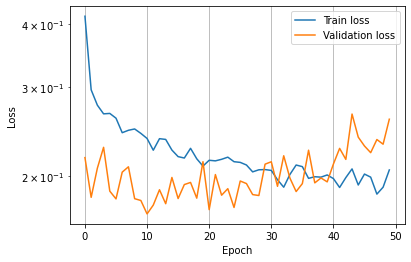

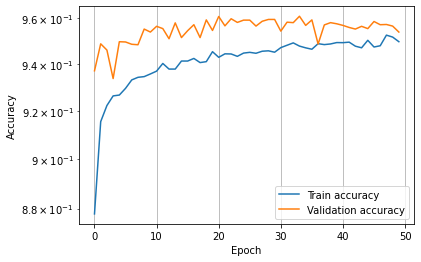



##### MODEL: 2/3 #####


Hyperparameters combination:
 {'lr': 0.001}
-> Epoch 1

Train loss: 0.5039899349212646
Accuracy on training set: 0.8506600000000001

Validation loss: 0.21165917813777924
Accuracy on validation set: 0.9368

-> Epoch 2

Train loss: 0.24010002613067627
Accuracy on training set: 0.92742

Validation loss: 0.16143053770065308
Accuracy on validation set: 0.9519

-> Epoch 3

Train loss: 0.1923874169588089
Accuracy on training set: 0.94266

Validation loss: 0.13254563510417938
Accuracy on validation set: 0.9603

-> Epoch 4

Train loss: 0.16443026065826416
Accuracy on training set: 0.9507599999999999

Validation loss: 0.11780506372451782
Accuracy on validation set: 0.9637

-> Epoch 5

Train loss: 0.14669153094291687
Accuracy on training set: 0.9556

Validation loss: 0.11448469012975693
Accuracy on validation set: 0.9662

-> Epoch 6

Train loss: 0.13305345177650452
Accuracy on training set: 0.9589000000000001

Validation loss: 0.10869821906089783
Accuracy on validation 

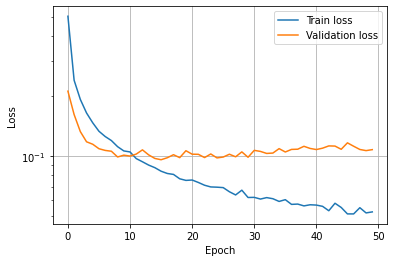

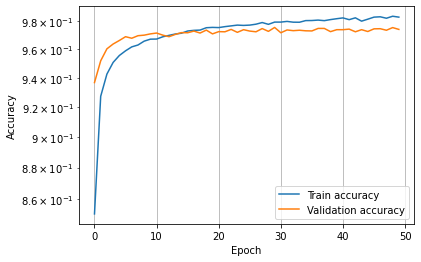



##### MODEL: 3/3 #####


Hyperparameters combination:
 {'lr': 0.0001}
-> Epoch 1

Train loss: 1.2263500690460205
Accuracy on training set: 0.6591200000000002

Validation loss: 0.5399063229560852
Accuracy on validation set: 0.8663

-> Epoch 2

Train loss: 0.5487671494483948
Accuracy on training set: 0.8393400000000001

Validation loss: 0.3808974325656891
Accuracy on validation set: 0.8978

-> Epoch 3

Train loss: 0.43543145060539246
Accuracy on training set: 0.87174

Validation loss: 0.32418087124824524
Accuracy on validation set: 0.9115

-> Epoch 4

Train loss: 0.38288262486457825
Accuracy on training set: 0.8888600000000001

Validation loss: 0.29249119758605957
Accuracy on validation set: 0.9179

-> Epoch 5

Train loss: 0.3427525758743286
Accuracy on training set: 0.9000800000000001

Validation loss: 0.264468789100647
Accuracy on validation set: 0.9239

-> Epoch 6

Train loss: 0.3162620961666107
Accuracy on training set: 0.9085

Validation loss: 0.24424591660499573
Accuracy on valid

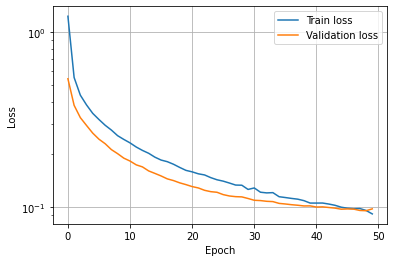

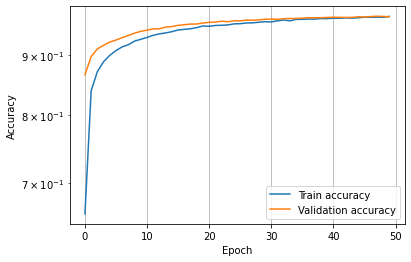

In [ ]:
# Adam grid search

combinations_dict_Adam = ParameterGrid(hyperparam_grid_Adam) # Combinations dict
scores_hyperpar_Adam = [] # List of tuples with the score of the model and the set of hyperparameters for that score
number_combinations = 3 # Number of the all combinations (3)
model_number = 1 # Counter for the grid search

for hyperparam_combination in combinations_dict_Adam:

  model_Adam = Net()
  model_Adam_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
  model_Adam.to(model_Adam_device)
  optimizer = Adam_optimizer(model_Adam.parameters(), lr = hyperparam_combination["lr"])
  num_epochs = 50

  print(f"\n\n##### MODEL: {model_number}/{number_combinations} #####\n")
  print("\nHyperparameters combination:\n", hyperparam_combination)
  model_number += 1
  train_loss, accuracy_train_scores, validation_loss, accuracy_val_scores = train_function(model_Adam, model_Adam_device, train_dataloader_new, validation_dataloader, num_epochs, optimizer)
  print("\n\n\nFINAL RESULT:")
  print(f"Final loss on validation set: {validation_loss[-1]}")
  print(f"Final accuracy on validation set: {accuracy_val_scores[-1]}")

  # Plot of losses and accuracies
  print("Plot of train and validation loss:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(train_loss, label='Train loss')
  plt.semilogy(validation_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  print("Plot of train and validation accuracy:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(accuracy_train_scores, label='Train accuracy')
  plt.semilogy(accuracy_val_scores, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

  scores_hyperpar_Adam.append((validation_loss[-1], accuracy_val_scores[-1], hyperparam_combination)) # Last validation, last accuracy and hyperparameters

In [ ]:
# Best model Adam (we consider the best accuracy)

best_score_validation_Adam = max(scores_hyperpar_Adam, key=operator.itemgetter(1))[0]
best_score_accuracy_Adam = max(scores_hyperpar_Adam, key=operator.itemgetter(1))[1]
best_hyperpars_Adam = max(scores_hyperpar_Adam, key=operator.itemgetter(1))[2]
print("Best validation and accuracy score:\n", best_score_validation_Adam, best_score_accuracy_Adam)
print("\nBest hyperparameters:\n", best_hyperpars_Adam)

Best validation and accuracy score:
 0.107554615 0.9741

Best hyperparameters:
 {'lr': 0.001}


#### AdaGrad grid search

In [ ]:
# Dict of lists of hyperparameters AdaGrad

hyperparam_grid_AdaGrad = {"lr": [0.01, 0.001, 0.0001]}



##### MODEL: 1/3 #####


Hyperparameters combination:
 {'lr': 0.01}
-> Epoch 1

Train loss: 0.468013197183609
Accuracy on training set: 0.8615600000000001

Validation loss: 0.26154056191444397
Accuracy on validation set: 0.924

-> Epoch 2

Train loss: 0.30234941840171814
Accuracy on training set: 0.91034

Validation loss: 0.2182254195213318
Accuracy on validation set: 0.9353

-> Epoch 3

Train loss: 0.26361238956451416
Accuracy on training set: 0.9236199999999999

Validation loss: 0.19724377989768982
Accuracy on validation set: 0.9395

-> Epoch 4

Train loss: 0.24131415784358978
Accuracy on training set: 0.9301200000000001

Validation loss: 0.18468260765075684
Accuracy on validation set: 0.9443

-> Epoch 5

Train loss: 0.22403396666049957
Accuracy on training set: 0.9347799999999999

Validation loss: 0.17217421531677246
Accuracy on validation set: 0.9479

-> Epoch 6

Train loss: 0.21473927795886993
Accuracy on training set: 0.9368200000000001

Validation loss: 0.1648501455783844
Accu

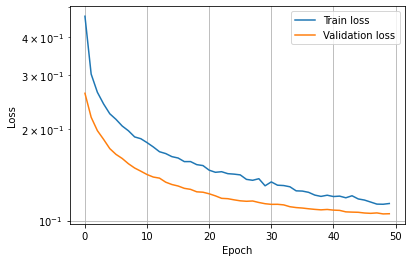

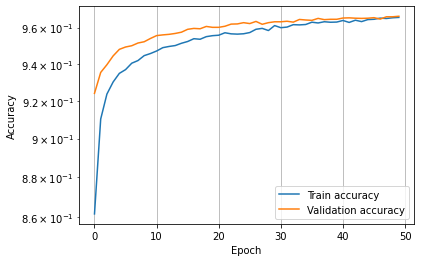



##### MODEL: 2/3 #####


Hyperparameters combination:
 {'lr': 0.001}
-> Epoch 1

Train loss: 1.3121047019958496
Accuracy on training set: 0.6547200000000001

Validation loss: 0.8028493523597717
Accuracy on validation set: 0.8188

-> Epoch 2

Train loss: 0.8118702173233032
Accuracy on training set: 0.7639000000000001

Validation loss: 0.6152600646018982
Accuracy on validation set: 0.8521

-> Epoch 3

Train loss: 0.6886910200119019
Accuracy on training set: 0.7990799999999999

Validation loss: 0.5382658243179321
Accuracy on validation set: 0.8684

-> Epoch 4

Train loss: 0.6262421607971191
Accuracy on training set: 0.81774

Validation loss: 0.49398672580718994
Accuracy on validation set: 0.8752

-> Epoch 5

Train loss: 0.5840498208999634
Accuracy on training set: 0.8294400000000001

Validation loss: 0.46258652210235596
Accuracy on validation set: 0.8824

-> Epoch 6

Train loss: 0.5592029690742493
Accuracy on training set: 0.8366800000000001

Validation loss: 0.44134634733200073
Accurac

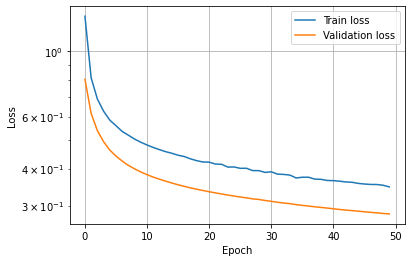

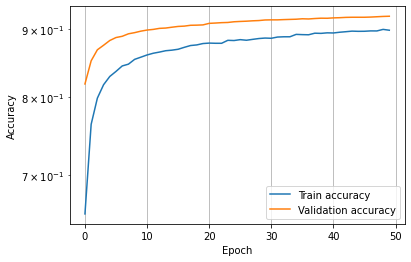



##### MODEL: 3/3 #####


Hyperparameters combination:
 {'lr': 0.0001}
-> Epoch 1

Train loss: 2.2555253505706787
Accuracy on training set: 0.25258

Validation loss: 2.2165684700012207
Accuracy on validation set: 0.3971

-> Epoch 2

Train loss: 2.193434000015259
Accuracy on training set: 0.37692000000000003

Validation loss: 2.158010482788086
Accuracy on validation set: 0.4962

-> Epoch 3

Train loss: 2.1415162086486816
Accuracy on training set: 0.42988

Validation loss: 2.105441093444824
Accuracy on validation set: 0.5383

-> Epoch 4

Train loss: 2.0935394763946533
Accuracy on training set: 0.46392

Validation loss: 2.0565402507781982
Accuracy on validation set: 0.5579

-> Epoch 5

Train loss: 2.0492324829101562
Accuracy on training set: 0.4872

Validation loss: 2.010615587234497
Accuracy on validation set: 0.5733

-> Epoch 6

Train loss: 2.0087926387786865
Accuracy on training set: 0.50412

Validation loss: 1.9674415588378906
Accuracy on validation set: 0.5859

-> Epoch 7

Train los

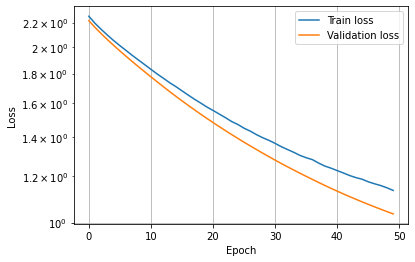

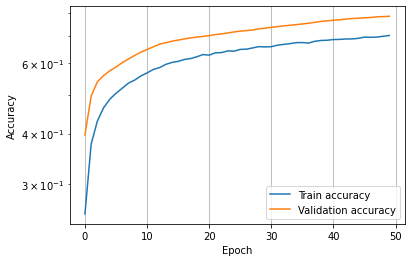

In [ ]:
# AdaGrad grid search

combinations_dict_AdaGrad = ParameterGrid(hyperparam_grid_AdaGrad) # Combinations dict
scores_hyperpar_AdaGrad = [] # List of tuples with the score of the model and the set of hyperparameters for that score
number_combinations = 3 # Number of the all combinations (3)
model_number = 1 # Counter for the grid search

for hyperparam_combination in combinations_dict_AdaGrad:

  model_AdaGrad = Net()
  model_AdaGrad_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
  model_AdaGrad.to(model_AdaGrad_device)
  optimizer = AdaGrad_optimizer(model_AdaGrad.parameters(), lr = hyperparam_combination["lr"])
  num_epochs = 50

  print(f"\n\n##### MODEL: {model_number}/{number_combinations} #####\n")
  print("\nHyperparameters combination:\n", hyperparam_combination)
  model_number += 1
  train_loss, accuracy_train_scores, validation_loss, accuracy_val_scores = train_function(model_AdaGrad, model_AdaGrad_device, train_dataloader_new, validation_dataloader, num_epochs, optimizer)
  print("\n\n\nFINAL RESULT:")
  print(f"Final loss on validation set: {validation_loss[-1]}")
  print(f"Final accuracy on validation set: {accuracy_val_scores[-1]}")

  # Plot of losses and accuracies
  print("Plot of train and validation loss:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(train_loss, label='Train loss')
  plt.semilogy(validation_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  print("Plot of train and validation accuracy:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(accuracy_train_scores, label='Train accuracy')
  plt.semilogy(accuracy_val_scores, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

  scores_hyperpar_AdaGrad.append((validation_loss[-1], accuracy_val_scores[-1], hyperparam_combination)) # Last validation, last accuracy and hyperparameters

In [ ]:
# Best model AdaGrad (we consider the best accuracy)

best_score_validation_AdaGrad = max(scores_hyperpar_AdaGrad, key=operator.itemgetter(1))[0]
best_score_accuracy_AdaGrad = max(scores_hyperpar_AdaGrad, key=operator.itemgetter(1))[1]
best_hyperpars_AdaGrad = max(scores_hyperpar_AdaGrad, key=operator.itemgetter(1))[2]
print("Best validation and accuracy score:\n", best_score_validation_AdaGrad, best_score_accuracy_AdaGrad)
print("\nBest hyperparameters:\n", best_hyperpars_AdaGrad)

Best validation and accuracy score:
 0.10529574 0.9663

Best hyperparameters:
 {'lr': 0.01}


#### Deep Frank-Wolf grid search

In [ ]:
# Dict of lists of hyperparameters DFW

hyperparam_grid_DFW = {"eta":[0.01, 0.001, 0.0001]}



##### MODEL: 1/3 #####


Hyperparameters combination:
 {'eta': 0.01}
-> Epoch 1

Train loss: 1.3014216423034668
Accuracy on training set: 0.61172

Validation loss: 0.5086866021156311
Accuracy on validation set: 0.8648

-> Epoch 2

Train loss: 0.5247176885604858
Accuracy on training set: 0.84374

Validation loss: 0.3503049910068512
Accuracy on validation set: 0.9013

-> Epoch 3

Train loss: 0.40947774052619934
Accuracy on training set: 0.8805200000000001

Validation loss: 0.2947543263435364
Accuracy on validation set: 0.913

-> Epoch 4

Train loss: 0.3541722297668457
Accuracy on training set: 0.89676

Validation loss: 0.2579304575920105
Accuracy on validation set: 0.9253

-> Epoch 5

Train loss: 0.31312036514282227
Accuracy on training set: 0.9101400000000001

Validation loss: 0.22858905792236328
Accuracy on validation set: 0.9345

-> Epoch 6

Train loss: 0.28398096561431885
Accuracy on training set: 0.9164200000000001

Validation loss: 0.20722080767154694
Accuracy on validation set: 

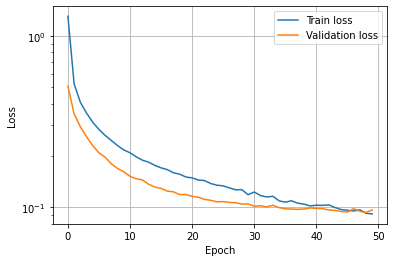

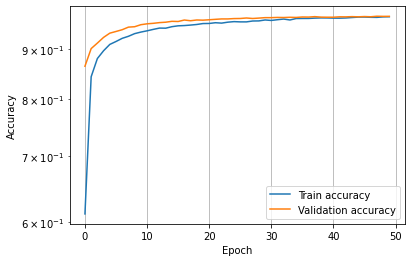



##### MODEL: 2/3 #####


Hyperparameters combination:
 {'eta': 0.001}
-> Epoch 1

Train loss: 2.2735981941223145
Accuracy on training set: 0.20074

Validation loss: 2.226473569869995
Accuracy on validation set: 0.3534

-> Epoch 2

Train loss: 2.153165578842163
Accuracy on training set: 0.3748

Validation loss: 2.0327999591827393
Accuracy on validation set: 0.499

-> Epoch 3

Train loss: 1.8929990530014038
Accuracy on training set: 0.49657999999999997

Validation loss: 1.6585476398468018
Accuracy on validation set: 0.639

-> Epoch 4

Train loss: 1.4998176097869873
Accuracy on training set: 0.59176

Validation loss: 1.213742971420288
Accuracy on validation set: 0.7187

-> Epoch 5

Train loss: 1.1628376245498657
Accuracy on training set: 0.65842

Validation loss: 0.9168875217437744
Accuracy on validation set: 0.7775

-> Epoch 6

Train loss: 0.959649920463562
Accuracy on training set: 0.70584

Validation loss: 0.7528830170631409
Accuracy on validation set: 0.8079

-> Epoch 7

Train loss:

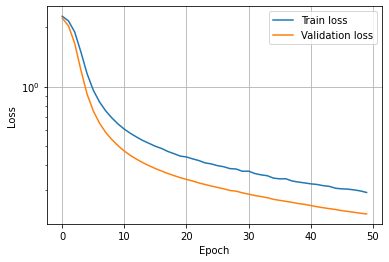

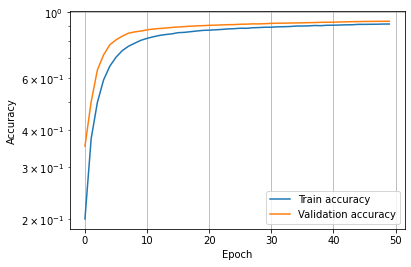



##### MODEL: 3/3 #####


Hyperparameters combination:
 {'eta': 0.0001}
-> Epoch 1

Train loss: 2.3043155670166016
Accuracy on training set: 0.0786

Validation loss: 2.300485134124756
Accuracy on validation set: 0.0598

-> Epoch 2

Train loss: 2.2984158992767334
Accuracy on training set: 0.09596

Validation loss: 2.2943012714385986
Accuracy on validation set: 0.0929

-> Epoch 3

Train loss: 2.2922251224517822
Accuracy on training set: 0.12688000000000002

Validation loss: 2.2878434658050537
Accuracy on validation set: 0.138

-> Epoch 4

Train loss: 2.2857789993286133
Accuracy on training set: 0.15978000000000003

Validation loss: 2.2809500694274902
Accuracy on validation set: 0.2034

-> Epoch 5

Train loss: 2.278731346130371
Accuracy on training set: 0.19800000000000006

Validation loss: 2.2736151218414307
Accuracy on validation set: 0.2672

-> Epoch 6

Train loss: 2.2714550495147705
Accuracy on training set: 0.23124

Validation loss: 2.2657134532928467
Accuracy on validation set: 0.3

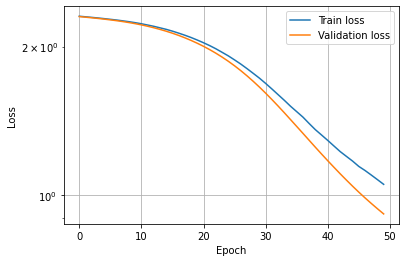

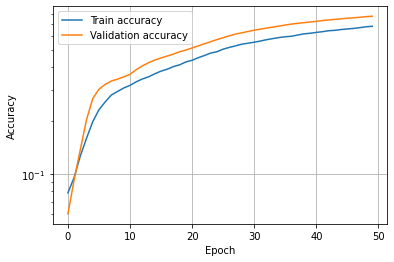

In [ ]:
# DFW grid search

combinations_dict_DFW = ParameterGrid(hyperparam_grid_DFW) # Combinations dict
scores_hyperpar_DFW = [] # List of tuples with the score of the model and the set of hyperparameters for that score
number_combinations = 3 # Number of the all combinations ()
model_number = 1 # Counter for the grid search

for hyperparam_combination in combinations_dict_DFW:

  model_DFW = Net()
  model_DFW_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
  model_DFW.to(model_DFW_device)
  optimizer = DFW_optimizer(model_DFW.parameters(), eta = hyperparam_combination["eta"])
  num_epochs = 50

  print(f"\n\n##### MODEL: {model_number}/{number_combinations} #####\n")
  print("\nHyperparameters combination:\n", hyperparam_combination)
  model_number += 1
  train_loss, accuracy_train_scores, validation_loss, accuracy_val_scores = train_function(model_DFW, model_DFW_device, train_dataloader_new, validation_dataloader, num_epochs, optimizer)
  print("\n\n\nFINAL RESULT:")
  print(f"Final loss on validation set: {validation_loss[-1]}")
  print(f"Final accuracy on validation set: {accuracy_val_scores[-1]}")

  # Plot of losses and accuracies
  print("Plot of train and validation loss:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(train_loss, label='Train loss')
  plt.semilogy(validation_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  print("Plot of train and validation accuracy:\n")
  plt.figure(figsize=(6,4))
  plt.semilogy(accuracy_train_scores, label='Train accuracy')
  plt.semilogy(accuracy_val_scores, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

  scores_hyperpar_DFW.append((validation_loss[-1], accuracy_val_scores[-1], hyperparam_combination)) # Last validation, last accuracy and hyperparameters

In [ ]:
# Best model DFW (we consider the best accuracy)

best_score_validation_DFW = max(scores_hyperpar_DFW, key=operator.itemgetter(1))[0]
best_score_accuracy_DFW = max(scores_hyperpar_DFW, key=operator.itemgetter(1))[1]
best_hyperpars_DFW = max(scores_hyperpar_DFW, key=operator.itemgetter(1))[2]
print("Best validation and accuracy score:\n", best_score_validation_DFW, best_score_accuracy_DFW)
print("\nBest hyperparameters:\n", best_hyperpars_DFW)

Best validation and accuracy score:
 0.09626861 0.9721

Best hyperparameters:
 {'eta': 0.01}


### Final testing and comparison

In [ ]:
# Training on the entire training dataset and testing on test set

# List with optimizer name
optimizers_list = ["Adam", "AdaGrad", "DFW"]

# Epochs
num_epochs = 100

# Dict with the lists of losses (train and test) and accuracies (train and test)
Adam_dict = {"train_losses": [], "accuracy_train_scores":[], "test_losses":[], "accuracy_test_scores":[]}
AdaGrad_dict = {"train_losses": [], "accuracy_train_scores":[], "test_losses":[], "accuracy_test_scores":[]}
DFW_dict = {"train_losses": [], "accuracy_train_scores":[], "test_losses":[], "accuracy_test_scores":[]}

for name in optimizers_list:
  
  if name == "Adam":

    final_model_Adam = Net()
    final_model_Adam_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
    final_model_Adam.to(final_model_Adam_device)
    optimizer = Adam_optimizer(final_model_Adam.parameters(), lr = best_hyperpars_Adam["lr"])

    print("\n\n##### OPTIMIZER:", name, "#####\nTRAINING/TESTING\n")
    # Now we will use all the  train dataset and obviously the test dataloader instead of validation one
    Adam_dict["train_losses"], Adam_dict["accuracy_train_scores"], Adam_dict["test_losses"], Adam_dict["accuracy_test_scores"] = train_function(final_model_Adam, final_model_Adam_device, train_dataloader, test_dataloader, num_epochs, optimizer)


  if name == "AdaGrad":

    final_model_AdaGrad = Net()
    final_model_AdaGrad_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
    final_model_AdaGrad.to(final_model_AdaGrad_device)
    optimizer = AdaGrad_optimizer(final_model_AdaGrad.parameters(), lr = best_hyperpars_AdaGrad["lr"])

    print("\n\n##### OPTIMIZER:", name, "#####\nTRAINING/TESTING\n")
    # Now we will use all the  train dataset and obviously the test dataloader instead of validation one
    AdaGrad_dict["train_losses"], AdaGrad_dict["accuracy_train_scores"], AdaGrad_dict["test_losses"], AdaGrad_dict["accuracy_test_scores"] = train_function(final_model_AdaGrad, final_model_AdaGrad_device, train_dataloader, test_dataloader, num_epochs, optimizer)


  if name == "DFW":

    final_model_DFW = Net()
    final_model_DFW_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
    final_model_DFW.to(final_model_DFW_device)
    optimizer = DFW_optimizer(final_model_DFW.parameters(), eta = best_hyperpars_DFW["eta"])

    print("\n\n##### OPTIMIZER:", name, "#####\nTRAINING/TESTING\n")
    # Now we will use all the  train dataset and obviously the test dataloader instead of validation one
    DFW_dict["train_losses"], DFW_dict["accuracy_train_scores"], DFW_dict["test_losses"], DFW_dict["accuracy_test_scores"] = train_function(final_model_DFW, final_model_DFW_device, train_dataloader, test_dataloader, num_epochs, optimizer)


print("\n\n\nFINAL RESULTS FOR EACH OPTIMIZER\n\n")
print("Adam test loss:", Adam_dict["test_losses"][-1],"\n", "Adam test accuracy:", Adam_dict["accuracy_test_scores"][-1], "\n\n")
print("AdaGrad test loss:", AdaGrad_dict["test_losses"][-1],"\n", "AdaGrad test accuracy:", AdaGrad_dict["accuracy_test_scores"][-1], "\n\n")
print("DFW test loss:", DFW_dict["test_losses"][-1],"\n", "DFW test accuracy:", DFW_dict["accuracy_test_scores"][-1], "\n\n")



##### OPTIMIZER: Adam #####
TRAINING/TESTING

-> Epoch 1

Train loss: 0.45556753873825073
Accuracy on training set: 0.8651333333333334

Validation loss: 0.18144364655017853
Accuracy on validation set: 0.9449

-> Epoch 2

Train loss: 0.22480647265911102
Accuracy on training set: 0.9338166666666666

Validation loss: 0.13286182284355164
Accuracy on validation set: 0.959

-> Epoch 3

Train loss: 0.17986157536506653
Accuracy on training set: 0.9456666666666668

Validation loss: 0.11430951952934265
Accuracy on validation set: 0.9655

-> Epoch 4

Train loss: 0.15718267858028412
Accuracy on training set: 0.9532666666666667

Validation loss: 0.11393740028142929
Accuracy on validation set: 0.9642

-> Epoch 5

Train loss: 0.14115417003631592
Accuracy on training set: 0.9569333333333333

Validation loss: 0.10073985904455185
Accuracy on validation set: 0.9697

-> Epoch 6

Train loss: 0.13013583421707153
Accuracy on training set: 0.9601000000000001

Validation loss: 0.1058003380894661
Accuracy on 

### Comparison plots of accuracy and loss 

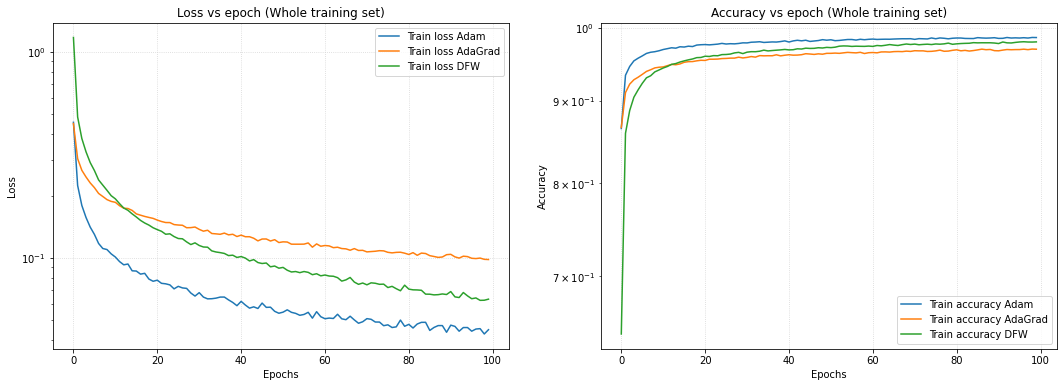

In [ ]:
# We use the train losses and the train accuracy scores
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(18,6))
dict_list = [("Adam", Adam_dict), ("AdaGrad", AdaGrad_dict), ("DFW", DFW_dict)]

# Titles
ax1.set_title(f"Loss vs epoch (Whole training set)")    
ax2.set_title(f"Accuracy vs epoch (Whole training set)")

for name, opt_dict in dict_list:

  # Plots
  ax1.semilogy(opt_dict["train_losses"], label=f'Train loss {name}')
  ax2.semilogy(opt_dict["accuracy_train_scores"], label=f'Train accuracy {name}')

  # Grid, labels and legends
  ax1.grid(color='lightgrey' , linestyle=':')
  ax2.grid(color='lightgrey' , linestyle=':')

  ax1.set_xlabel("Epochs")
  ax2.set_xlabel("Epochs")

  ax1.set_ylabel("Loss")
  ax2.set_ylabel("Accuracy")
      
  ax1.legend()
  ax2.legend()

  fig.show()